<a href="https://colab.research.google.com/github/LucasAlegre/vote-network/blob/master/vote_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import libraries

In [1]:
! pip install --user graphistry
! pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 47.5 MB/s eta 0:00:00


In [14]:
!pip install netbone

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.3/986.3 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/23

In [58]:
import graphistry
import pandas as pd
import urllib.request
import requests
from datetime import date
import numpy as np
from igraph import Graph, summary
import networkx as nx
import netbone
from netbone import disparity
from netbone.filters import threshold_filter, fraction_filter
from itertools import combinations
import os
# Init graphistry
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="LucasAlegre", password="lna123321")

DEBUG:graphistry.pygraphistry:@PyGraphistry login : org_name :None vs PyGraphistry.org_name() : None
DEBUG:graphistry.arrow_uploader:2. @ArrowUploader.__init__: After set self.org_name: None, self.__org_name : None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): hub.graphistry.com:443
DEBUG:urllib3.connectionpool:https://hub.graphistry.com:443 "POST /api-token-auth/ HTTP/1.1" 201 734
DEBUG:graphistry.pygraphistry:@PyGraphistry login After ArrowUploader.login: org_name :None vs PyGraphistry.org_name() : lucasalegre
DEBUG:graphistry.pygraphistry:1. @PyGraphistry refresh, org_name: lucasalegre
DEBUG:graphistry.pygraphistry:JWT refresh via token
DEBUG:graphistry.arrow_uploader:2. @ArrowUploader.__init__: After set self.org_name: lucasalegre, self.__org_name : lucasalegre
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): hub.graphistry.com:443
DEBUG:urllib3.connectionpool:https://hub.graphistry.com:443 "POST /api/v2/auth/token/refresh HTTP/1.1" 200 1197


## Data Retrieval and Processing

In [3]:
start_date = '2024-01-01' #@param {type:"date"}
end_date = '2025-09-05' #@param {type:"date"}
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [4]:
# Collect all votes between start and end dates
os.makedirs('data', exist_ok=True)
for year in range(start_date.year, end_date.year + 1):
    # Read or download votes
    path = 'data/votacoesVotos-{}.csv'.format(year)
    if not os.path.isfile(path):
      headers = {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'}
      url = 'https://dadosabertos.camara.leg.br/arquivos/votacoesVotos/csv/votacoesVotos-{}.csv'.format(year)
      request = urllib.request.Request(url, None, headers) #The assembled request
      response = urllib.request.urlopen(request)
      data = response.read() # The data u need
      with open(path, 'wb') as f:
          f.write(data)

    vote_data = pd.read_csv(path, sep=';')

    # Remove simbolic votes
    vote_data = vote_data[vote_data['voto'] != 'Simbólico']

    # Filter dates
    vote_data['dataHoraVoto'] = pd.to_datetime(vote_data['dataHoraVoto'])
    vote_data = vote_data.loc[(vote_data['dataHoraVoto'] >= start_date) & (vote_data['dataHoraVoto'] <= end_date)]
    vote_data.sort_values(by=['dataHoraVoto'], inplace=True)

    if year == start_date.year:
        votes = vote_data
    else:
        votes = pd.concat([votes, vote_data])
votes

,idVotacao,uriVotacao,dataHoraVoto,voto,deputado_id,deputado_uri,deputado_nome,deputado_siglaPartido,deputado_uriPartido,deputado_siglaUf,deputado_idLegislatura,deputado_urlFoto
32749,2367548-7,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-02-20 20:48:55,Artigo 17,160541,https://dadosabertos.camara.leg.br/api/v2/depu...,Arthur Lira,PP,https://dadosabertos.camara.leg.br/api/v2/part...,AL,57,https://www.camara.leg.br/internet/deputado/ba...
32905,2367548-7,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-02-20 20:49:10,Sim,198197,https://dadosabertos.camara.leg.br/api/v2/depu...,Greyce Elias,AVANTE,https://dadosabertos.camara.leg.br/api/v2/part...,MG,57,https://www.camara.leg.br/internet/deputado/ba...
33129,2367548-7,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-02-20 20:49:10,Sim,220598,https://dadosabertos.camara.leg.br/api/v2/depu...,Tarcísio Motta,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,57,https://www.camara.leg.br/internet/deputado/ba...
32895,2367548-7,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-02-20 20:49:11,Sim,204491,https://dadosabertos.camara.leg.br/api/v2/depu...,Gilberto Abramo,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,MG,57,https://www.camara.leg.br/internet/deputado/ba...
32733,2367548-7,https://dadosabertos.camara.leg.br/api/v2/vota...,2024-02-20 20:49:12,Sim,204356,https://dadosabertos.camara.leg.br/api/v2/depu...,Amaro Neto,REPUBLICANOS,https://dadosabertos.camara.leg.br/api/v2/part...,ES,57,https://www.camara.leg.br/internet/deputado/ba...
...,...,...,...,...,...,...,...,...,...,...,...,...
33072,2430953-280,https://dadosabertos.camara.leg.br/api/v2/vota...,2025-09-04 00:11:54,Sim,69871,https://dadosabertos.camara.leg.br/api/v2/depu...,Bacelar,PV,https://dadosabertos.camara.leg.br/api/v2/part...,BA,57,https://www.camara.leg.br/internet/deputado/ba...
33371,2430953-280,https://dadosabertos.camara.leg.br/api/v2/vota...,2025-09-04 00:12:31,Sim,220598,https://dadosabertos.camara.leg.br/api/v2/depu...,Tarcísio Motta,PSOL,https://dadosabertos.camara.leg.br/api/v2/part...,RJ,57,https://www.camara.leg.br/internet/deputado/ba...
33211,2430953-280,https://dadosabertos.camara.leg.br/api/v2/vota...,2025-09-04 00:12:48,Não,74273,https://dadosabertos.camara.leg.br/api/v2/depu...,Jefferson Campos,PL,https://dadosabertos.camara.leg.br/api/v2/part...,SP,57,https://www.camara.leg.br/internet/deputado/ba...
33105,2430953-280,https://dadosabertos.camara.leg.br/api/v2/vota...,2025-09-04 00:13:12,Sim,88256,https://dadosabertos.camara.leg.br/api/v2/depu...,Clodoaldo Magalhães,PV,https://dadosabertos.camara.leg.br/api/v2/part...,PE,57,https://www.camara.leg.br/internet/deputado/ba...


In [5]:
def get_total_expenses(deputy_id, start_date, end_date):
    #expenses = []
    total = 0.0
    years = '&'.join(['ano={}'.format(year) for year in range(start_date.year, end_date.year+1)])
    url = "https://dadosabertos.camara.leg.br/api/v2/deputados/{}/despesas?{}&itens=100000&ordem=ASC&ordenarPor=ano".format(deputy_id, years)
    read_all = False
    while not read_all:
        read_all = True
        page = requests.get(url).json()
        if 'dados' not in page:
            break
        total += sum([e['valorDocumento'] for e in page['dados']])
        #this_expenses = [{'tipo': e['tipoDespesa'], 'valor': e['valorDocumento']} for e in page['dados']]
        #expenses.extend(this_expenses)
        for link in page['links']:
            if link['rel'] == 'next':
                url = link['href']
                read_all = False
                break
    return total

def get_deputy_info(deputy_id):
    url = 'https://dadosabertos.camara.leg.br/api/v2/deputados/{}'.format(deputy_id)
    data = requests.get(url).json()['dados']
    ultimoStatus = data['ultimoStatus']
    today = date.today()
    nascimento = pd.to_datetime(data['dataNascimento'])
    idade = today.year - nascimento.year - ((today.month, today.day) < (nascimento.month, nascimento.day))
    return {'sexo': data['sexo'],
            'escolaridade': data['escolaridade'],
            'idade': idade,
            'e-mail': ultimoStatus['email'],
            'situação': ultimoStatus['situacao'],
            'cidade natal': data['municipioNascimento']}

In [6]:
#%% Take care of different names for same deputy
for group, df_group in votes.groupby('deputado_id'):
    votes['deputado_nome'].loc[votes['deputado_id'] == group] = sorted(df_group['deputado_nome'].unique())[0]

#%% Partidos que mudaram de nome
votes['deputado_siglaPartido'].replace('PMDB', 'MDB', inplace=True)
votes['deputado_siglaPartido'].replace('PRB', 'REPUBLICANOS', inplace=True)
votes['deputado_siglaPartido'].replace('PR', 'PL', inplace=True)
votes['deputado_siglaPartido'].replace('PATRIOTA', 'PATRI', inplace=True)
votes['deputado_siglaPartido'].replace('PPS', 'CIDADANIA', inplace=True)

# Logo dos partidos
party_logo = {}
for p in votes['deputado_uriPartido'].unique():
    if not pd.isna(p):
        dados = requests.get(p).json()['dados']
        if dados['sigla'] == 'MDB':
            party_logo[p] = 'https://logodownload.org/wp-content/uploads/2018/04/mdb-logo-partido.png'
        elif dados['sigla'] == 'SOLIDARIEDADE':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/commons/f/fe/Logomarca_do_Partido_Solidariedade.png'
        elif dados['sigla'] == 'PATRI':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/en/8/8e/Patriota_logo.png'
        elif dados['sigla'] == 'REPUBLICANOS':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/en/0/0d/Republicanos_logo.png'
        elif dados['sigla'] == 'PL':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/commons/0/03/PL-logo.jpg'
        elif dados['sigla'] == 'CIDADANIA':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/commons/d/d7/Logo_do_Cidadania_23.png'
        elif dados['sigla'] == 'NOVO':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/commons/b/b5/Novo30_AOC.png'
        elif dados['sigla'] == 'UNIÃO':
            party_logo[p] = 'https://upload.wikimedia.org/wikipedia/commons/7/73/Uni%C3%A3o_Brasil_logo.svg'
        else:
            party_logo[p] = dados['urlLogo']

#all_data['deputado_siglaPartido'].replace('PPL', np.nan, inplace=True) # PPL foi incorporado
#all_data['deputado_siglaPartido'].replace('PRP', np.nan, inplace=True) # PRP foi incorporado
#all_data['deputado_siglaPartido'].replace('PHS', np.nan, inplace=True) # PHS foi incorporado
# all_data = pd.merge(all_data, motions_themes, on="idVotacao", how="inner")
#all_data['deputado_siglaPartido'].fillna('S.PART.', inplace=True)
# all_data.groupby('idVotacao')['voto'].count()

#all_data.to_csv('votos_{}_to_{}.csv'.format(start_date, end_date), index=False)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/partidos/37903 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/partidos/36898 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/partidos/36839 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/partidos/37908 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:4

## Graph Construction

In [7]:
def generalized_similarity(m, min_eps=0.001, max_iter=1000):
    """ Balázs Kovács, "A generalized model of relational similarity," Social Networks, 32(3), July 2010, pp. 197–211
        Based on: https://github.com/dzinoviev/generalizedsimilarity
    """
    arcs0 = m - m.mean(axis=1)[:, np.newaxis]
    arcs1 = m.T - m.mean(axis=0)[:, np.newaxis]

    eps = min_eps + 1
    N = np.eye(m.shape[1])

    iters = 0
    while (eps > min_eps and iters < max_iter) or np.isnan(N).any():
        M = arcs0.dot(N).dot(arcs0.T)
        m = np.sqrt(M.diagonal())
        M = ((M / (m+1e-8)).T / (m+1e-8)).T

        Np = arcs1.dot(M).dot(arcs1.T)
        n = np.sqrt(Np.diagonal())
        Np = ((Np / (n+1e-8)).T / (n+1e-8)).T
        eps = np.abs(Np - N).max()
        N = Np

        iters += 1
    return M

def pearson_correlation(m):
    arcs0 = m - m.mean(axis=1)[:, np.newaxis]
    arcs1 = m.T - m.mean(axis=0)[:, np.newaxis]
    M = arcs0.dot(arcs0.T)
    m = np.sqrt(M.diagonal())
    M = ((M / m).T / m).T
    return M

def filter_edges(edges_list, num_nodes, threshold=None, density=0.1):
    edges, weights = [], []
    if threshold is not None:
        for e in edges_list:
            if e[1] >= threshold:
                edges.append(e[0])
                weights.append(e[1])
    else:
        count = int(num_nodes * (num_nodes - 1) * density / 2)
        edges_list.sort(reverse=True, key=lambda e: e[1])
        edges_list = edges_list[:count]
        edges = [e[0] for e in edges_list]
        weights = [e[1] for e in edges_list]
    return edges, weights

In [8]:
# Vote Matrix
reps = votes['deputado_nome'].unique()
rep_to_ind = {reps[i]: i for i in range(len(reps))}
motions = votes['idVotacao'].unique()
motion_to_ind = {motions[i]: i for i in range(len(motions))}
parties = [p for p in votes['deputado_siglaPartido'].unique() if pd.notna(p)]

vote_matrix = np.zeros((len(reps), len(motions)))
df_grouped = votes.groupby(['idVotacao', 'deputado_nome'])
for group, df_group in df_grouped:
    voto = df_group['voto'].values[0]
    i = rep_to_ind[group[1]]
    j = motion_to_ind[group[0]]
    if voto == "Sim":
        vote_matrix[i,j] = 1
    elif voto == "Não":
        vote_matrix[i,j] = -1

In [13]:
# Edges Generation
M = generalized_similarity(vote_matrix)
edges = []
for dep1, dep2 in combinations(range(len(reps)), 2):
    if M[dep1,dep2] > 0:
        edges.append(((dep1,dep2), M[dep1,dep2]))

In [69]:
# --- Original igraph graph ---
graph = Graph(graph_attrs={'name': 'Câmara dos Deputados'}, directed=False)
graph.add_vertices(reps)  # reps is your list of names
filer_edges, weights = filter_edges(edges, num_nodes=graph.vcount(), threshold=None, density=1)
graph.add_edges(filer_edges)
graph.es['weight'] = weights
graph.es['similarity'] = graph.es['weight']

# Normalize weights to [0,1]
maxw = max(graph.es['weight'])
minw = min(graph.es['weight'])
graph.es['weight'] = [(e - minw) / (maxw - minw) for e in graph.es['weight']]

print(graph.vcount(), graph.ecount())

# --- Convert to NetworkX while preserving names ---
G_nx = graph.to_networkx()  # igraph uses indices as nodes here
mapping = {v.index: v["name"] for v in graph.vs}  # index → name
G_nx = nx.relabel_nodes(G_nx, mapping)

# --- Apply netbone filters ---
backbone = disparity(G_nx, weight='weight')
# G_nx = threshold_filter(backbone, 0.4)
G_nx = fraction_filter(backbone, 0.3)

# --- Convert back to igraph, restoring names ---
graph = Graph.from_networkx(G_nx)
graph.vs["name"] = list(G_nx.nodes)  # explicitly restore names

print(graph.vcount(), graph.ecount())

599 102297
Disparity Filter
599 30690


In [44]:
backdf = backbone.to_dataframe()

In [45]:
backdf.describe()

,source,target,_igraph_index,weight,p_value,similarity
count,102297.000000,102297.000000,102297.000000,102297.000000,102297.000000,102297.000000
mean,198.865861,400.252969,51148.000000,0.987864,0.366471,0.987890
std,142.268094,141.491793,29530.744581,0.059606,0.009849,0.059479
min,0.000000,2.000000,0.000000,0.000000,0.015254,0.002134
25%,76.000000,303.000000,25574.000000,0.996559,0.366471,0.996566
50%,174.000000,424.000000,51148.000000,0.999227,0.366902,0.999228
75%,302.000000,519.000000,76722.000000,0.999857,0.367116,0.999857
max,597.000000,598.000000,102296.000000,1.000000,1.000000,1.000000


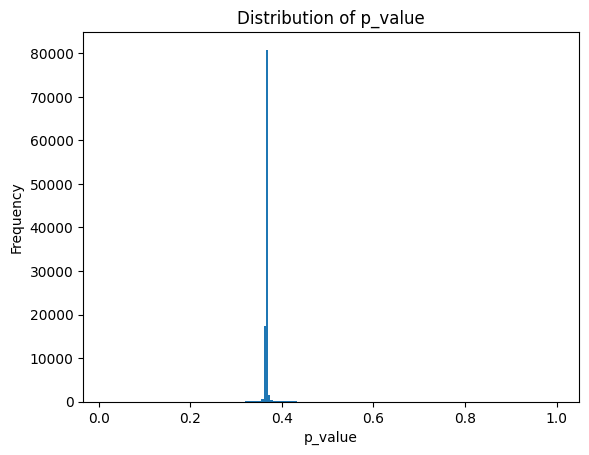

In [67]:
import matplotlib.pyplot as plt

plt.hist(backdf['p_value'], bins=200)
plt.xlabel('p_value')
plt.ylabel('Frequency')
plt.title('Distribution of p_value')
plt.show()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.12/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

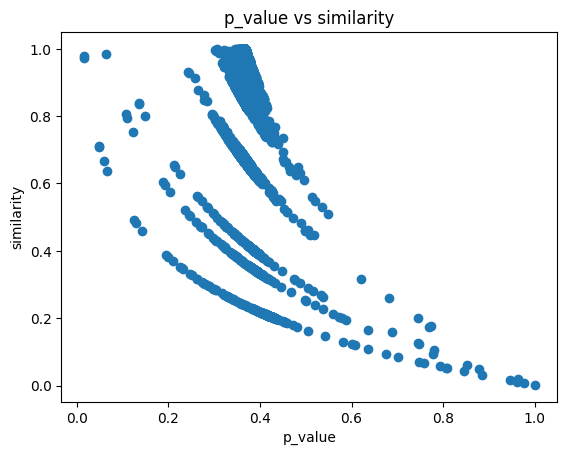

In [63]:
import matplotlib.pyplot as plt

plt.scatter(backdf['p_value'], backdf['similarity'])
plt.xlabel('p_value')
plt.ylabel('similarity')
plt.title('p_value vs similarity')
plt.show()

In [73]:
# Community Detection
graph.vs['community'] = graph.community_leiden(weights='weight', objective_function='modularity', resolution_parameter=1, n_iterations=100).membership
graph.vs['community_leiden'] = [str(c) for c in graph.vs['community']]
print(graph.vs['community'])
print(graph.modularity(graph.vs['community'], weights='weight'))
""" graph.delete_edges()
edges, weights = filter_edges(edges, num_nodes=graph.vcount(), threshold=0.0, density=0.1)
graph.add_edges(edges)
graph.es['weight'] = weights
graph.es['similarity'] = weights """

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 

" graph.delete_edges()\nedges, weights = filter_edges(edges, num_nodes=graph.vcount(), threshold=0.0, density=0.1)\ngraph.add_edges(edges)\ngraph.es['weight'] = weights\ngraph.es['similarity'] = weights "

In [74]:
# Add info to nodes
info = [votes[votes['deputado_nome']==dep] for dep in graph.vs['name']]
graph.vs['Foto'] = [x['deputado_urlFoto'].values[-1] for x in info]
graph.vs['UF'] = [x['deputado_siglaUf'].values[-1] for x in info]
graph.vs['Partido'] = [x['deputado_siglaPartido'].values[-1] for x in info]
graph.vs['URL'] =  [x['deputado_uri'].values[-1] for x in info]
graph.vs['Partido URI'] =  [x['deputado_uriPartido'].values[-1] for x in info]
# graph.vs['Total Despesas (reais)'] = [get_total_expenses(x['deputado_id'].values[-1], start_date, end_date) for x in info]
for i, x in enumerate(info):
    for k, v in get_deputy_info(x['deputado_id'].values[-1]).items():
        if i == 0:
            graph.vs[k] = ['' for _ in range(len(graph.vs))]
        graph.vs[i][k] = v

graph.vs['betweenness'] = graph.betweenness()
graph.vs['closeness'] = graph.closeness()

summary(graph)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/deputados/74084 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/deputados/74270 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/deputados/227401 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.leg.br:443 "GET /api/v2/deputados/213274 HTTP/1.1" 200 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dadosabertos.camara.leg.br:443
DEBUG:urllib3.connectionpool:https://dadosabertos.camara.le

IGRAPH UNW- 599 30690 -- 
+ attr: Foto (v), Partido (v), Partido URI (v), UF (v), URL (v), _n_implicit (v), _nx_name (v), betweenness (v), cidade natal (v), closeness (v), community (v), community_leiden (v), e-mail (v), escolaridade (v), idade (v), name (v), sexo (v), situação (v), p_value (e), similarity (e), weight (e)


## Visualization

In [75]:
g = graphistry.bind(source='src', destination='dst',
                    point_label='name',
                    edge_weight='similarity',
                    edge_label='similarity',
                    edge_size='similarity',
                    point_color='community',
                    point_size='name')
(e_df, n_df) = g.igraph2pandas(graph)
g = g.nodes(n_df).edges(e_df)
g = g.nodes(lambda g: g._nodes.assign(community=g._nodes['community'].astype('int32')))
g = g.addStyle(bg={'color': 'white'}, page={'title': 'Câmara dos Deputados'})
g = g.encode_point_icon('Partido URI', categorical_mapping=party_logo, shape='circle')
g = g.settings(url_params={
    'pageTitle': 'Câmara dos Deputados',
    'play': 2000,
    'menu': True,
    'info': True,
    'strongGravity': True,
    'showArrows': False,
    'pointSize': 5.0,
    'pointsOfInterestMax': 100,
    'edgeInfluence': 1.0,
    'showLabels': True, 'showLabelOnHover': True,
    'showPointsOfInterest': True, 'showPointsOfInterestLabel': True, 'showLabelPropertiesOnHover': True})
g.plot(render=True)

DEBUG:graphistry.PlotterBase:1. @PloatterBase plot: _pygraphistry.org_name: lucasalegre
DEBUG:graphistry.PlotterBase:2. @PloatterBase plot: self._pygraphistry.org_name: lucasalegre
DEBUG:graphistry.PlotterBase:3. @PloatterBase plot: self._pygraphistry.org_name: lucasalegre
DEBUG:graphistry.pygraphistry:1. @PyGraphistry refresh, org_name: lucasalegre
DEBUG:graphistry.pygraphistry:JWT refresh via token
DEBUG:graphistry.arrow_uploader:2. @ArrowUploader.__init__: After set self.org_name: lucasalegre, self.__org_name : lucasalegre
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): hub.graphistry.com:443
DEBUG:urllib3.connectionpool:https://hub.graphistry.com:443 "POST /api/v2/auth/token/refresh HTTP/1.1" 200 1197
DEBUG:graphistry.PlotterBase:4. @PloatterBase plot: self._pygraphistry.org_name: lucasalegre
DEBUG:graphistry.PlotterBase:_make_dataset (mode arrow, memoize True) name:[Untitled KMDMMJT85H] des:[] (e::<class 'pandas.core.frame.DataFrame'>, n::<class 'pandas.core.frame.